# Food Deserts in the United States [Phase Four Submission]

Carly Hu, Elena Joseph, Jason Kim, Anisha Saini

## Contents

1. __Introduction__
2. __Loading Data__
3. __Data Cleaning__
    1. National Data Cleaning
    2. New York Data Cleaning
4. __Data Description__
5. __Data Limitations__
6. __Pre-analysis hypotheses__
7. __Data Analysis__
    1. National Analysis
        1. Population visualizations
        2. Hypothesis testing
        3. Focus on Native Americans, hypothesis testing for regression 
    2. New York Analysis
        1. Population visualizations
        2. Hypothesis testing
        3. Focus on white population, hypothesis testing for regression
    3. Comparing US and NYS distributions
    4. Regression: Urban tracts
8. __Interpretation and Conclusion__
    1. Interpretation
    2. Conclusion
9. __Acknowledgements__
10. __Questions for Reviewers__


--- 

# Introduction

In this project, we are exploring food deserts present in the United States and its relation to race. A food desert is defined by the US Department of Agriculture as living beyond one mile from a grocery store in a urban or suburban area and beyond 10 miles from a grocery store in a rural area. The data source was the Food Access Research Atlas which measures access to supermarkets at various census tracts in terms of various demographic variables. This data source is maintained by the Economic Research Service (ERS) and U.S. Department of Agriculture (USDA). 

With this data, we were highly interested in exploring the distribution of food deserts in the United States as food is an essential need for life. Without access to food, the quality of people's life is compromised as they have to travel larger distances to purchase food. This extra distance not only compromsies people's time but also expects people to have access and be able to afford reliable transportation, in addition to any costs and time associated with grocery shopping. This does not even include any other implications, such as finding caretakers for elderly or children who may not be able to accompany the food shopper to the store. Thus, food inaccess can be highly intertwined with other issues, compromising the quality of life. 

We have seen throughout history that there tends to be significant inequality among different races for basic treatment and needs. We decided to explore this relation, as well as the difference in this relation between New York State, where our team is based in, and the national United States. Thus, our __research questions__ are as follow: 
- Is there a statistically significant difference in terms of access to food in the US across different races, where statisically signficance is defined by having a p-value less than 0.05? 
- If so, does New York state reflect national levels of food access inequality across races? 

Through our analysis, we have found that there does exist a statistically significant difference in terms of food access across race, specifically Native Americans on the national level, and white Americans in New York state. We also found that New York state does not reflect national levels of food access inequality across races. 

We hope these findings can inform lawmakers of what can be done in certain areas to help people facing food insecurity and thus, create effective legislation to curb such issues and improve the quality of lives of those currently struggling. 


---

# Loading Data

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
import statsmodels.api as sm

import duckdb, sqlalchemy

ModuleNotFoundError: No module named 'statsmodels'

In [209]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [210]:
#Loading in the dataset
df = pd.read_csv('food_access_research_atlas.csv')
print(df.shape)
df.head()

(72864, 147)


,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,221,1622,217,14,0,14,45,44,26,112
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,214,888,1217,5,0,5,55,75,87,202
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,439,2576,647,17,5,11,117,87,108,120
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,904,4086,193,18,4,11,74,85,19,82
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,1126,8666,1437,296,9,48,310,355,198,488


This data frame displays the first five rows of data after loading the dataset from the source. 


---

# Data Cleaning
### National Data Cleaning

After observing that there are 147 columns in this dataset, we decided to filter out only the columns relevant to our research question.

In [211]:
#Filtering out the columns that are of interest to the research question from the dataset
%sql half << SELECT State, County, lawhitehalf as White, lablackhalf as Black, laasianhalf as Asian,\
lanhopihalf as Pacific_Islander, laaianhalf as American_Indian, laomultirhalf as Other, lahisphalf as Hispanic FROM df
%sql one << SELECT State, County, lawhite1 as White, lablack1 as Black, laasian1 as Asian,\
lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other, lahisp1 as Hispanic FROM df
%sql ten << SELECT State, County, lawhite10 as White, lablack10 as Black, laasian10 as Asian,\
lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other, lahisp10 as Hispanic FROM df
%sql twenty << SELECT State, County, lawhite20 as White, lablack20 as Black, laasian20 as Asian,\
lanhopi20 as Pacific_Islander, laaian20 as American_Indian, laomultir20 as Other, lahisp20 as Hispanic FROM df

Returning data to local variable half
Returning data to local variable one
Returning data to local variable ten
Returning data to local variable twenty


We seperated out the original data into four smaller dataframes that represents the population of the people living that many miles or further away from the nearest supermarket. Below, we simply melted the dataframe to make it easier to plot using seaborn package.

In [212]:
# Cleaning and rearranging the data to make it easier to work with
cleaned_half = pd.melt(half, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_one = pd.melt(one, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ten = pd.melt(ten, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_twenty = pd.melt(twenty, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()

pop_at_each_dist = pd.DataFrame({'Race':cleaned_half['Race'], 'HalfMile':cleaned_half['Population'], \
'OneMile':cleaned_one['Population'],'TenMiles':cleaned_ten['Population'],'TwentyMiles':cleaned_twenty['Population']})
pop_at_each_dist.to_csv('pop_at_each_dist.csv')

pop_at_each_dist

,Race,HalfMile,OneMile,TenMiles,TwentyMiles
0,American_Indian,2.159289e+06,1.466854e+06,3.385671e+05,154033.742896
1,Asian,7.930698e+06,3.113423e+06,2.297992e+04,3825.977523
2,Black,2.437161e+07,1.129574e+07,3.393879e+05,6923.342056
3,Hispanic,2.771349e+07,1.177554e+07,3.906380e+05,69964.466858
4,Other,1.551538e+07,6.789885e+06,2.397046e+05,37668.043287
5,Pacific_Islander,3.298089e+05,1.577236e+05,4.905566e+03,735.266505
6,White,1.657078e+08,1.007398e+08,4.312731e+06,431478.337847


As mentioned above, this is the filtered data frame containing the population of each race at the various distances.

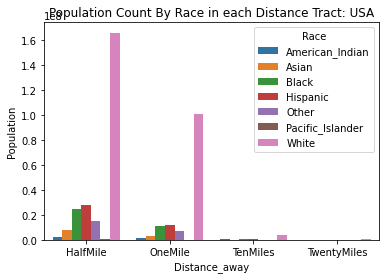

In [213]:
# Visualize population distrbution at each distances
pop_at_each_dist_melted = pd.melt(pop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Population')
sns.barplot(data=pop_at_each_dist_melted,x='Distance_away', y='Population', hue='Race').set(title='Population Count By Race in each Distance Tract: USA')
plt.show()

This bar graph displays the population of each race in the US, as highlighted in the legend, in terms of distances from a supermarket.

We also wanted to know the total population we are working with grouped by race so we extracted the population data below.

In [214]:
# Getting the total population of different races in the US from the original dataset
%sql total_population << SELECT TractWhite AS White,TractBlack AS Black, TractAsian AS Asian, TractNHOPI AS Pacific_Islander, \
TractAIAN AS American_Indian, TractOMultir AS Other, TractHispanic AS Hispanic FROM df

total_population = pd.melt(total_population, var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
total_population.to_csv('total_population_df.csv')

total_population

Returning data to local variable total_population


,Race,Population
0,American_Indian,2932248
1,Asian,14674252
2,Black,38929319
3,Hispanic,50477594
4,Other,28116441
5,Pacific_Islander,540013
6,White,223553265


As mentioned above, this data frame represents the total population for each race in the US, as accounted by this dataset.

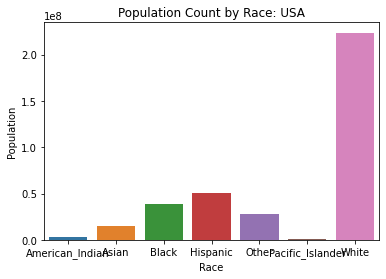

In [215]:
# Visualize population distribution across races
sns.barplot(data=total_population,x='Race', y='Population').set(title='Population Count by Race: USA')
plt.show()

This bar graph showcases the population of each race in the US. As seen, the white population is the highest racial group. 

### NY Data Cleaning

In [216]:
%sql ny_half << SELECT State, County, lawhitehalf as White, lablackhalf as Black, laasianhalf as Asian,\
lanhopihalf as Pacific_Islander, laaianhalf as American_Indian, laomultirhalf as Other, lahisphalf \
as Hispanic FROM df WHERE State = 'New York'
%sql ny_one << SELECT State, County, lawhite1 as White, lablack1 as Black, laasian1 as Asian,\
lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other, lahisp1 as Hispanic \
FROM df WHERE State = 'New York'
%sql ny_ten << SELECT State, County, lawhite10 as White, lablack10 as Black, laasian10 as Asian,\
lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other, lahisp10 as Hispanic FROM df \
WHERE State = 'New York'
%sql ny_twenty << SELECT State, County, lawhite20 as White, lablack20 as Black, laasian20 as Asian,\
lanhopi20 as Pacific_Islander, laaian20 as American_Indian, laomultir20 as Other, lahisp20 as Hispanic FROM df \
WHERE State = 'New York'

cleaned_ny_half = pd.melt(ny_half, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_one = pd.melt(ny_one, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_ten = pd.melt(ny_ten, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
cleaned_ny_twenty = pd.melt(ny_twenty, id_vars =['State','County'], var_name='Race', value_name='Population').groupby('Race').sum().reset_index()

ny_pop_at_each_dist = pd.DataFrame({'Race':cleaned_ny_half['Race'], 'HalfMile':cleaned_ny_half['Population'], \
'OneMile':cleaned_ny_one['Population'],'TenMiles':cleaned_ny_ten['Population'],'TwentyMiles':cleaned_ny_twenty['Population']})
ny_pop_at_each_dist.to_csv('ny_pop_at_each_dist.csv')
ny_pop_at_each_dist

Returning data to local variable ny_half
Returning data to local variable ny_one
Returning data to local variable ny_ten
Returning data to local variable ny_twenty


,Race,HalfMile,OneMile,TenMiles,TwentyMiles
0,American_Indian,3.455974e+04,2.110377e+04,787.270739,1.000088
1,Asian,2.628393e+05,9.479964e+04,346.265939,0.000265
2,Black,5.924514e+05,1.717682e+05,2408.879887,0.715675
3,Hispanic,6.036213e+05,2.148840e+05,2023.171552,4.505039
4,Other,3.583624e+05,1.331233e+05,1583.693025,2.110698
5,Pacific_Islander,2.482825e+03,1.263375e+03,27.135887,0.000000
6,White,6.927099e+06,4.036151e+06,82422.596879,372.440094


This data frame drops several columns and cleans the data to keep the relevant columns to our dataset and to New York. We renamed the race variables to make the race in question more clear. We also used the melt function to aggregate all the distances from a food desert into one column. This data frame displays the columns in terms of New York, which are race and the population counts by various distances.

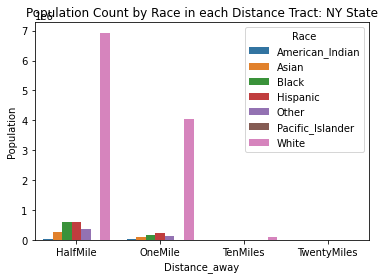

In [130]:
# New York 
ny_pop_at_each_dist_melted = pd.melt(ny_pop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Population')
sns.barplot(data=ny_pop_at_each_dist_melted,x='Distance_away', y='Population', hue='Race')\
.set(title='Population Count by Race in each Distance Tract: NY State')
plt.show()

This bar graph display the population of each race within the state of NY, as highlighted in the legend, in terms of distances from a supermarket. 

In [131]:
# NY total population
%sql ny_total_population << SELECT TractWhite AS White,TractBlack AS Black, TractAsian AS Asian, TractNHOPI AS Pacific_Islander, \
TractAIAN AS American_Indian, TractOMultir AS Other, TractHispanic AS Hispanic FROM df WHERE State = 'New York'

ny_total_population = pd.melt(ny_total_population, var_name='Race', value_name='Population').groupby('Race').sum().reset_index()
ny_total_population.to_csv('ny_total_population.csv')
ny_total_population

Returning data to local variable ny_total_population


,Race,Population
0,American_Indian,106906
1,Asian,1420244
2,Black,3073800
3,Hispanic,3416922
4,Other,2027412
5,Pacific_Islander,8766
6,White,12740974


This data frame represents the total population of different races in New York from the original dataset.

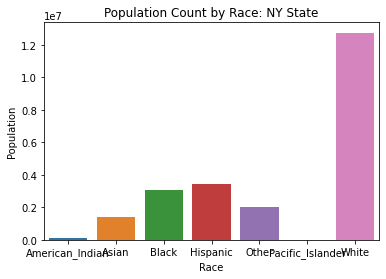

In [132]:
# New York State population distribution
sns.barplot(data=ny_total_population, x='Race', y='Population').set(title='Population Count by Race: NY State')
plt.show()

This bar graph display the population of each race in terms of New York State, as highlighted in the legend, in terms of distances from a supermarket. 


---

# Data Description

### What are the observations (rows) and the attributes (columns)?
The rows specify the 72864 different census-tracts in the entire nation with 4906 just in New York state. Out of total 147 columns, 28 provide data on racial distribution, namely counts within White populations, Black or African American populations, Asian populations, Native Hawaiian or Other Pacific Islander populations, American Indian or Alaska Native populations, Other/Multiple Race populations, and Hispanic or Latino populations beyond ½ mile, 1 mile, 10 miles, and 20 miles from the nearest supermarket.
### Why was this dataset created?
Food insecurity is a pertinent public health problem in the United States. This dataset aims to provide insights on access to food and map these measures to contextual census-tract-level characteristics.
### Who funded the creation of the dataset?
The Food Access Research Atlas is funded by the Economic Research Service (ERS) and U.S. Department of Agriculture (USDA). We are thankful for the collection and distribution of this data to enable us to conduct this analysis on food insecurity in the US. 
### What processes might have influenced what data was observed and recorded and what was not?
The 2010 Census of Population and Housing and the 2019 STARS directory/2019 Trade Dimensions TDLinx directory are both comprehensive forms of data collection for populations and grocery store locations, respectively. However, the collection dates of 2010 and 2019 mean that more recent data about population movement and grocery store construction and demolition are not considered.

### What preprocessing was done, and how did the data come to be in the form that you are using?
- In preprocessing, we dropped several columns that weren’t relevant to our analysis and included columns regarding country, state, and variables for the count of the low-access population of each race at beyond a distance of 0.5 miles, 1 miles, 10 miles, and 20 miles from a supermarket. The state and country were used as identifier variables. Several csv files were created to account for the variables for the count of the low-access population of each race at beyond a specific distance, country, and state. For example, the half_df.csv showcases a dataframe that has columns ‘Race’ and ‘Population’, referencing population count; this dataframe accounts for the count of each race beyond 0.5 miles away from a supermarket. We did note that for some dataframes, such as the 20 miles away, there were many 0s within the dataframe. We realized that this did not indicate missing data but it indicated that certain populations did not exist at a location at that distance. Therefore, we decided to account for these 0s within our dataset.
- Furthermore, a dataframe, pop_at_each_dist, was created that aggregates the information of the dataframe at the various distances from the supermarket. It adds a column, named ‘Distance_away’, to the dataframe, in addition to the columns of ‘Race’ and ‘Population’, that enables viewers to understand the count of population of a certain race at a certain distance from the supermarket. 
- However, because the White race has a higher proportion of the population generally. We realized that the White population would then always be significantly higher across all distance tracts (0.5 miles, 1 mile, etc) in terms of food access. It was important to analyze each race in terms of their racial population; thus, we decided to compare the proportions of each race at each distance tract to analyze if a racial population has a statistically significant difference in terms of food access, compared to other racial populations. 
- To do this, we created a dataframe, total_population, to aggregate the total population of different races in the US after pulling data of the variables TractWhite, TractBlack, and so on for each race from the original dataset. 
- From there, we created the df, total_population_melted, which presents the data by unpivoting the Race column to become a column value, rather than the row format it was in the previous data frame. Moreover, the name ‘Population” was added to communicate that the numbers represented population per race. Thus, there are two columns “Race” and “Population” to showcase the population of each race in the US. 
- Now the data is set up to help get the proportions of each race. A proportion column was added to each corresponding distance and was calculated accordingly, by dividing the population count for that specific race at the specific distance by the total U.S. population. After, a melt processing occurred to create a new dataframe where this data was aggregated in a more succinct format with 3 columns: Race, Distance_away, and Proportion. This dataframe, prop_at_each_dist_melted, enabled creation of a corresponding data visualization.
- Moreover, we realized that there may be overlap between these different tracts of low-access racial population counts. However, because we are determining if there is a statistically significant difference in low-access in terms of race, we can analyze each tract independently, such as looking at low-access population counts beyond 0.5 miles and beyond 1 miles. At this step, one is able to conduct analysis to determine if there is a statistically significant difference in food access between various races in the US total population. 
- In terms of analyzing New York, these aforementioned steps are repeated but are completed in terms of New York, meaning that there was filtering the data to keep only New York relevant data and in terms of population analysis, this was completed in terms of the New York State population. 
- After these steps, one is able to conduct analysis to determine if there is a statistically significant difference in food access between various races in the New York State population. This can then be compared to that of the United States population to determine whether the food access in New York State in terms of race reflects the national food access by race.  
- The “raw” data was saved in addition to the every cleaned dataframe created within our GitHub repository, enabling users to access any data frame of their choice, raw or cleaned, that best suits their needs for any unanticipated future uses. This can be accessed at ‘https://github.coecis.cornell.edu/ch862/info2950-finalproject’ and are the various csv files within the repository.
- Preprocessing was done on a Jupyter Notebook, utilizing Python, SQL, as well as the Python packages of pandas and seaborn. This can be accessed at our GitHub repository, ‘https://github.coecis.cornell.edu/ch862/info2950-finalproject’, in the file named ‘Phase Two.ipynb’.


### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
The data collected was demographic data on people and their proximity to food deserts. The people involved in the data collection from the Census are aware of the data collection as it is mandated that all residents in the United State must disclose information in the Census survey. As this Census information provides demographic information, they are aware that this data can be utlizied for other purposes in which the population is analyzed by area and demographic information, such as this food desert project. This logic can also applied from the data collection on income, vehicle availability, and SNAP from the 2014-18 American Community Survey as it was required by law and thus, people will be aware of the data collection and that it can be used for population analysis based on the data of the collected variables. The 2019 STARS directory/2019 Trade Dimensions TDLinx directory are directories of stores and thus, this question is not applicable as people were not involved in the data collection. 
### Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box).
The raw source data can be found within the following Cornell Google Drive link: https://drive.google.com/drive/folders/1BEDQN9lTk-JAM5VzSr7iSjpQ-JLpUUT6?usp=sharing



---

# Data Limitations

The data we are using is pulled from the Food Access Research Atlas, which is a data set maintained by the Economic Research Service (ERS) and U.S. Department of Agriculture (USDA) (https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/#data).

Below is information from the ERS regarding the sources of this data:
- Population data on age, race, ethnicity, and residence in quarters are from the __2010 US Census__
- Urban or rural residence data are from the __2019 US census__
- Data on income, vehicle availability, and SNAP  are from the __2014-18 American Community Survey__
- Supermarket/supercenter/grocery store data, meant to represent sources of "affordable and nutritious food" are from __two 2019 lists combined__: one list contains stores that receive SNAP benefits, and the other is from TDLinx.

__Limitations:__
1. All of the data is sourced from 2010-2019, thus, any conclusions or predictions we make will only apply to this time period.
2. While the data is reliably sourced, it contains population data from 2010, which is somewhat outdated. Thus, if we are to make predictions, we must keep in mind that the models rely on some data collected over 10 years ago and do not account for today's population demographics.
3. Data from the American Community Survey comes from a randomly selected sample of Americans, and it is likely that many Americans do not fill out the survey though it is "required by law." Thus, the sample may be somewhat biased to Americans who are willing to or have the time to fill out a survey about their income and other resources. 
4. Our analysis (as of Phase II) will focus only on race, thus, we are ignoring the potential influence of intersectionality (income, gender, etc.) on food accessibility.  




--- 

# Pre-analysis Hypotheses

Hypothesis 1: There will be a statistically significant difference in terms of food access among different racial groups.  
Hypothesis 2: Food access levels across different races in New York State will not be a representative sample of national food access levels across different races.



---

# Data Analysis


We found from our initial preprocessing that the White population greatly outnumbers the population of other races, streching the axis too much for us to make any notable observations about their distributions. To circumvent this issue, we will be focusing on the proportion of people in food desserts within the same race and then compare that ratio with the different races for both the nation as a whole and New York State.

## National Analysis

Below, we are simply calculating the proportion of people that lives certain miles away from a supermarket and creating a new dataframe.

In [133]:
# Adding proportion column to dataframes of each distance
cleaned_half['Proportion'] = cleaned_half['Population'] / total_population['Population']
cleaned_one['Proportion'] = cleaned_one['Population'] / total_population['Population']
cleaned_ten['Proportion'] = cleaned_ten['Population'] / total_population['Population']
cleaned_twenty['Proportion'] = cleaned_twenty['Population'] / total_population['Population']

# Combining four dataframes with the proportions into one dataframe that contains both population and proportion
pop_prop_at_each_dist = pop_at_each_dist.copy() # Creating deep copy to not affect the previous dataset and corresponding graphs
pop_prop_at_each_dist.insert(2, 'HalfProportion', cleaned_half['Proportion'])
pop_prop_at_each_dist.insert(4, 'OneProportion', cleaned_one['Proportion'])
pop_prop_at_each_dist.insert(6, 'TenProportion', cleaned_ten['Proportion'])
pop_prop_at_each_dist.insert(8, 'TwentyProportion', cleaned_twenty['Proportion'])
pop_prop_at_each_dist.to_csv('pop_prop_at_each_dist.csv')

pop_prop_at_each_dist

,Race,HalfMile,HalfProportion,OneMile,OneProportion,TenMiles,TenProportion,TwentyMiles,TwentyProportion
0,American_Indian,2.159289e+06,0.736394,1.466854e+06,0.500249,3.385671e+05,0.115463,154033.742896,0.052531
1,Asian,7.930698e+06,0.540450,3.113423e+06,0.212169,2.297992e+04,0.001566,3825.977523,0.000261
2,Black,2.437161e+07,0.626048,1.129574e+07,0.290160,3.393879e+05,0.008718,6923.342056,0.000178
3,Hispanic,2.771349e+07,0.549026,1.177554e+07,0.233282,3.906380e+05,0.007739,69964.466858,0.001386
4,Other,1.551538e+07,0.551826,6.789885e+06,0.241492,2.397046e+05,0.008525,37668.043287,0.001340
5,Pacific_Islander,3.298089e+05,0.610743,1.577236e+05,0.292074,4.905566e+03,0.009084,735.266505,0.001362
6,White,1.657078e+08,0.741245,1.007398e+08,0.450630,4.312731e+06,0.019292,431478.337847,0.001930


As aforementioned, this data frame includes the proportion of the population for each distance tract, in addition to the previous population information it held.

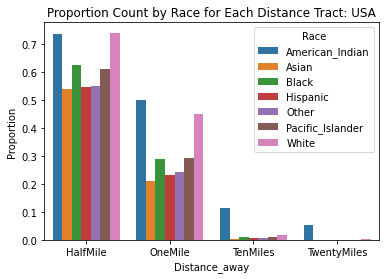

In [134]:
# Creating dataframe with only proportions at each distance
prop_at_each_dist = pd.DataFrame({'Race':cleaned_half['Race'], 'HalfMile':cleaned_half['Proportion'], \
'OneMile':cleaned_one['Proportion'],'TenMiles':cleaned_ten['Proportion'],'TwentyMiles':cleaned_twenty['Proportion']})
prop_at_each_dist.to_csv('prop_at_each_dist.csv')

# Visualizing the racial distribution of proportions of food desserts at each distance
prop_at_each_dist_melted = pd.melt(prop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Proportion')
sns.barplot(data=prop_at_each_dist_melted, x='Distance_away', y='Proportion', hue='Race').set(title='Proportion Count by Race for Each Distance Tract: USA')
plt.show()

This bar graph displays the proportion of the population of each race at various distance tracts for the US. Here, we begin to notice how the American Indian and White population appear to have a higher proportion of people with lower access to supermarkets in each of the distances. 

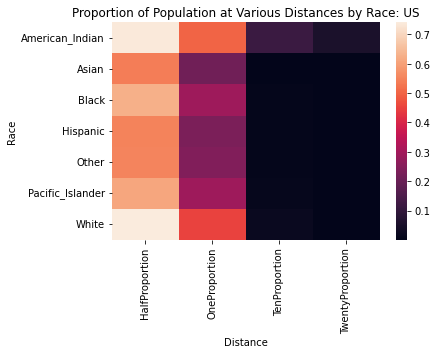

In [135]:
pop_prop_at_each_dist_heatmap = pd.melt(pop_prop_at_each_dist.drop(columns=['HalfMile','OneMile','TenMiles','TwentyMiles']),\
                                        id_vars='Race', var_name = 'Distance', value_name='Proportion')
heatmap_df = pop_prop_at_each_dist_heatmap.pivot("Race", "Distance", "Proportion")
ax = sns.heatmap(heatmap_df)
plt.title("Proportion of Population at Various Distances by Race: US")
plt.show()

This heatmap is another visualization of the proportions in terms of the US. We notice how the colors get darker as the distance increases. We will now try to dive deeper with the distributions within each distance below.

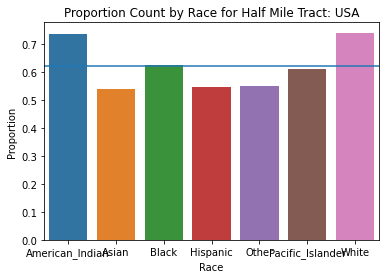

In [136]:
sns.barplot(data=cleaned_half, x='Race', y='Proportion').set(title='Proportion Count by Race for Half Mile Tract: USA')
plt.axhline(cleaned_half['Proportion'].mean())
plt.show()

This bar graph displays the proportion of each race in terms of the US population for those half a mile away from a supermarket. The blue horizontal line represents the national mean value of racial population proportion across all races for the half mile tract. As shown, American Indian and White is above the national mean while Black is at the national mean for food insecurity in this distance tract.

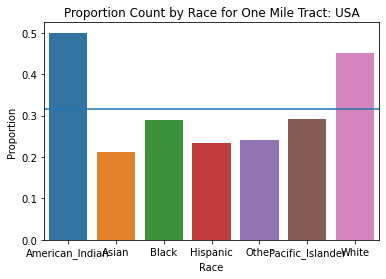

In [137]:
sns.barplot(data=cleaned_one, x='Race', y='Proportion').set(title='Proportion Count by Race for One Mile Tract: USA')
plt.axhline(cleaned_one['Proportion'].mean())

This bar graph displays the proportion of each race in terms of the US population for those one mile away from a supermarket. The blue horizontal line represents the national mean value of racial population proportion across all races for the one mile tract. As shown, American Indian and White is above the national mean for food insecurity in this distance tract.

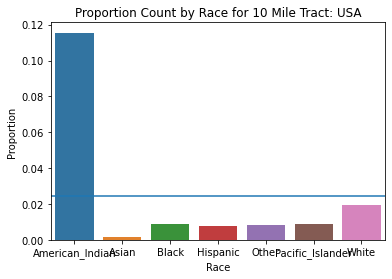

In [138]:
sns.barplot(data=cleaned_ten, x='Race', y='Proportion').set(title='Proportion Count by Race for 10 Mile Tract: USA')
plt.axhline(cleaned_ten['Proportion'].mean())

This bar graph displays the proportion of each race in terms of the US population for those ten miles away from a supermarket. The blue horizontal line represents the national mean value of racial population proportion across all races for the ten mile tract. As shown, American Indian is above the national mean for food insecurity in this distance tract.

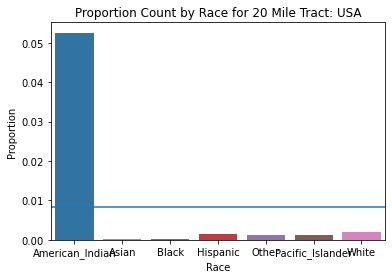

In [139]:
sns.barplot(data=cleaned_twenty, x='Race', y='Proportion').set(title='Proportion Count by Race for 20 Mile Tract: USA')
plt.axhline(cleaned_twenty['Proportion'].mean())

This bar graph displays the proportion of each race in terms of the US population for those twenty miles away from a supermarket. The blue horizontal line represents the national mean value of racial population proportion across all races for the twenty mile tracts. As shown, American Indian is above the national mean for food insecurity in this distance tract. 

### Hypothesis Test

In [140]:
def get_p(dataframe, mean, std, trials=1000):
    p_vals = np.array([])
    samples = np.random.normal(mean, std, size=trials)
    
    sns.histplot(samples)
    max_prop_index = dataframe['Proportion'].idxmax()
    plt.axvline(dataframe['Proportion'][max_prop_index], label=dataframe['Race'][max_prop_index], c='r')
    plt.legend(loc='upper left')

    for stat in dataframe['Proportion']:
        p_vals = np.append(p_vals, np.count_nonzero(samples>=stat)/trials)
    
    output = dataframe.copy()
    output['p-val'] = p_vals
    output['Significant'] = p_vals <=0.05
    
    return output

,Race,Population,Proportion,p-val,Significant
0,American_Indian,2.159289e+06,0.736394,0.092,False
1,Asian,7.930698e+06,0.540450,0.828,False
2,Black,2.437161e+07,0.626048,0.457,False
3,Hispanic,2.771349e+07,0.549026,0.801,False
4,Other,1.551538e+07,0.551826,0.790,False
5,Pacific_Islander,3.298089e+05,0.610743,0.539,False
6,White,1.657078e+08,0.741245,0.078,False


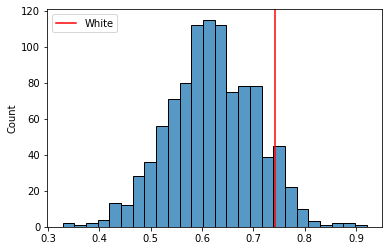

In [141]:
half_prop_mean = cleaned_half['Proportion'].mean()
half_prop_std = cleaned_half['Proportion'].std()

half_prop_hypo = get_p(cleaned_half, half_prop_mean, half_prop_std)
half_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,1.466854e+06,0.500249,0.042,True
1,Asian,3.113423e+06,0.212169,0.818,False
2,Black,1.129574e+07,0.290160,0.586,False
3,Hispanic,1.177554e+07,0.233282,0.760,False
4,Other,6.789885e+06,0.241492,0.743,False
5,Pacific_Islander,1.577236e+05,0.292074,0.579,False
6,White,1.007398e+08,0.450630,0.107,False


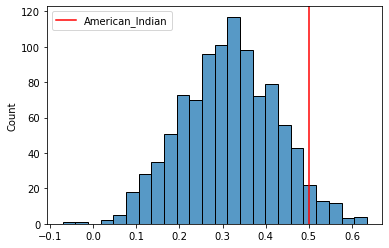

In [142]:
one_prop_mean = cleaned_one['Proportion'].mean()
one_prop_std = cleaned_one['Proportion'].std()

one_prop_hypo = get_p(cleaned_one, one_prop_mean, one_prop_std)
one_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,3.385671e+05,0.115463,0.011,True
1,Asian,2.297992e+04,0.001566,0.708,False
2,Black,3.393879e+05,0.008718,0.642,False
3,Hispanic,3.906380e+05,0.007739,0.648,False
4,Other,2.397046e+05,0.008525,0.642,False
5,Pacific_Islander,4.905566e+03,0.009084,0.640,False
6,White,4.312731e+06,0.019292,0.527,False


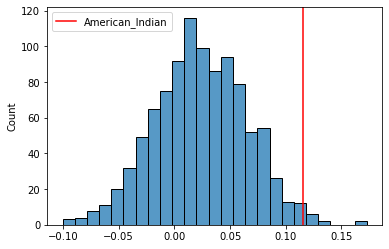

In [143]:
ten_prop_mean = cleaned_ten['Proportion'].mean()
ten_prop_std = cleaned_ten['Proportion'].std()

ten_prop_hypo = get_p(cleaned_ten, ten_prop_mean, ten_prop_std)
ten_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,3.385671e+05,0.115463,0.013,True
1,Asian,2.297992e+04,0.001566,0.705,False
2,Black,3.393879e+05,0.008718,0.644,False
3,Hispanic,3.906380e+05,0.007739,0.656,False
4,Other,2.397046e+05,0.008525,0.648,False
5,Pacific_Islander,4.905566e+03,0.009084,0.643,False
6,White,4.312731e+06,0.019292,0.554,False


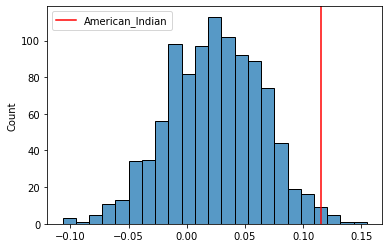

In [144]:
ten_prop_mean = cleaned_ten['Proportion'].mean()
ten_prop_std = cleaned_ten['Proportion'].std()

ten_prop_hypo = get_p(cleaned_ten, ten_prop_mean, ten_prop_std)
ten_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,154033.742896,0.052531,0.006,True
1,Asian,3825.977523,0.000261,0.649,False
2,Black,6923.342056,0.000178,0.650,False
3,Hispanic,69964.466858,0.001386,0.627,False
4,Other,37668.043287,0.001340,0.628,False
5,Pacific_Islander,735.266505,0.001362,0.628,False
6,White,431478.337847,0.001930,0.615,False


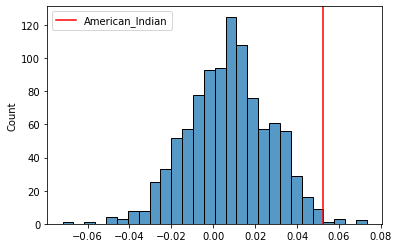

In [145]:
twenty_prop_mean = cleaned_twenty['Proportion'].mean()
twenty_prop_std = cleaned_twenty['Proportion'].std()

twenty_prop_hypo = get_p(cleaned_twenty, twenty_prop_mean, twenty_prop_std)
twenty_prop_hypo

From the above hypothesis tests, we can reject the null hypothesis that there is no inequality in terms of access to food being more than 10 miles away for the American Indian or Alaska native population. This probability is similar for tracks more than 20 miles away. This got us wondering if there is some underlying factor to explain for the higher proportion for the American Indian or Alaska native population specifically. Below, we will explore the dataset further to see if there is any relevant relationships with the American Indian or Alaska native population.

### American Indian or Alaska Native Population

We will begin by focusing down on tracts that have the greatest number of American Indian or Alaska native population. We will focus on tracts that are located 20 or more miles from a supermarket as this distance produced the largest difference between the mean and the observed proportion.


In [146]:
# Filter tracts with greatest American Indian or Alaska native 
most_aian_tracts = (twenty.drop(columns=['State','County']).max(axis=1) == twenty['American_Indian']) & (twenty['American_Indian'] > 0)
aian_twenty = twenty[most_aian_tracts]
aian_twenty.head()

,State,County,White,Black,Asian,Pacific_Islander,American_Indian,Other,Hispanic
1180,Alaska,Aleutians West,289.000003,32.0,178.000006,7.0,588.999996,90.000000,60.00000
1237,Alaska,Bethel,217.393210,4.0,3.000000,3.0,6355.155568,113.262140,33.13107
1239,Alaska,Bethel,174.051484,5.0,1.000000,0.0,1146.999987,121.000000,10.00000
1242,Alaska,Dillingham,81.622131,2.0,0.000000,2.0,1489.000202,154.999997,24.00000
1264,Alaska,Hoonah-Angoon,2.298670,0.0,0.052098,0.0,4.019764,0.275501,0.00000


<AxesSubplot:xlabel='Count', ylabel='State'>

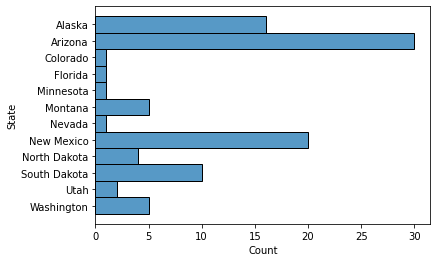

In [147]:
# Visualize State distribution
sns.histplot(aian_twenty, y='State')

From our initial observations, we can see that Arizona, New Mexico, Alaska, and South Dakota appear to be states with the greatest number of American Indian or Alaska native population tracts that are located 20 or more miles from a supermarket. We label a tract as American Indian or Alaska native population tract if the majority of the people that live 20 or more miles away from a supermarket belong to the American Indian or Alaska native population. 

### Hypothesis Testing for Regression

In order to further anlayze if there is an underlying factor that might provide further insight to the extremely high rate of low access to supermarkets with the American Indian or Alaska native population, we will perform a hypothesis testing for regression to determine if there is a relationship between the American Indian or Alaska native population tracts and five features from the original dataset.  

These five features are:  
&emsp;-low income population  
&emsp;-count of kids between 0-17  
&emsp;-count of seniors above 65  
&emsp;-count of housing units with no vehicle  
&emsp;-count of housing units receiving SNAP benefits  

Essentially, we will be performing a hypothesis test to determine if there is a relationship between any of these features with the tract being an American Indian or Alaska native population tract. 

In [148]:
# Cleaning the dataframe to get only columns of interest
%sql reg_df << SELECT State, County, TractLOWI AS LowIncome, TractKids AS Kids, TractSeniors AS Seniors, TractHUNV AS NoVehicle,\
TractSNAP AS SNAP FROM df 
reg_df.head()

Returning data to local variable reg_df


,State,County,LowIncome,Kids,Seniors,NoVehicle,SNAP
0,Alabama,Autauga,448,507,221,26,112
1,Alabama,Autauga,763,606,214,87,202
2,Alabama,Autauga,1578,894,439,108,120
3,Alabama,Autauga,1241,1015,904,19,82
4,Alabama,Autauga,2692,3162,1126,198,488


In the above data frame, we are filtering out the feature variables (x) from the original dataset and also adding the boolean column (y).

In [149]:
reg_df.corr()

,LowIncome,Kids,Seniors,NoVehicle,SNAP
LowIncome,1.000000,0.581498,0.171391,0.324969,0.787675
Kids,0.581498,1.000000,0.279977,0.032484,0.359257
Seniors,0.171391,0.279977,1.000000,0.096746,0.107757
NoVehicle,0.324969,0.032484,0.096746,1.000000,0.447400
SNAP,0.787675,0.359257,0.107757,0.447400,1.000000


There appears to be high correlation between low income and SNAP variables which makes sense since the SNAP program was designed to support the low income population. In order to avoid multicollinearity, we will be eliminating the SNAP feature when fitting our regression.

In [150]:
new_reg_df = reg_df.drop(columns='SNAP')
new_reg_df.head()

,State,County,LowIncome,Kids,Seniors,NoVehicle
0,Alabama,Autauga,448,507,221,26
1,Alabama,Autauga,763,606,214,87
2,Alabama,Autauga,1578,894,439,108
3,Alabama,Autauga,1241,1015,904,19
4,Alabama,Autauga,2692,3162,1126,198


Now that we have all the relevant features to fit into our model, by removing the SNAP column, we will normalize all the values to smooth out the distributions.

In [151]:
means = new_reg_df[['LowIncome','Kids','Seniors','NoVehicle']].mean()
stds = new_reg_df[['LowIncome','Kids','Seniors','NoVehicle']].std()
norm_reg_df = (new_reg_df[['LowIncome','Kids','Seniors','NoVehicle']] - means)/ stds
norm_reg_df.head()

,LowIncome,Kids,Seniors,NoVehicle
0,-0.987838,-0.827057,-0.939538,-0.518485
1,-0.677677,-0.666850,-0.959369,-0.253500
2,0.124804,-0.200794,-0.321954,-0.162276
3,-0.207019,-0.004986,0.995371,-0.548893
4,1.221692,3.469397,1.624288,0.228685


Below, we will be using the above normalized dataframe and print out the summary statistic to determine if any features have a relevant relationship with the American Indian or Alaska native population tracts.

In [152]:
# Splitting above dataset to fit regression
X_train, X_test, y_train, y_test = \
train_test_split(norm_reg_df, most_aian_tracts, test_size=0.3)

# Using statsmodel package to get summary statistics of the regression
model = sm.Logit(most_aian_tracts, norm_reg_df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                72864
Model:                          Logit   Df Residuals:                    72860
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                  -67.94
Time:                        14:53:14   Log-Likelihood:                -50505.
converged:                       True   LL-Null:                       -732.61
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LowIncome      0.0050      0.010      0.511      0.609      -0.014       0.024
Kids          -0.0013      0.010     -0.140      0.889      -0.020       0.017
Seniors       -0.0043      0.008     -0.549      0.583      -0.019       0.011
NoVehicle     -0.0004      0.008     -0.048      0.962      -0.016       0.015
==============================================================================
"""

From the above summary statistics, we can see that there are no significant p-values across the four features. In other words, we fail to reject the null hypothesis that there is no relationship between the features (low income, number of kids, number of seniors, and number of housing units without a vehicle) and the American Indian or Alaska native population tracts.


---

## New York Analysis

In [153]:
# Adding proportion column to each dataframes
cleaned_ny_half['Proportion'] = cleaned_ny_half['Population'] / ny_total_population['Population']
cleaned_ny_one['Proportion'] = cleaned_ny_one['Population'] / ny_total_population['Population']
cleaned_ny_ten['Proportion'] = cleaned_ny_ten['Population'] / ny_total_population['Population']
cleaned_ny_twenty['Proportion'] = cleaned_ny_twenty['Population'] / ny_total_population['Population']

# Combining four dataframes into one
ny_pop_prop_at_each_dist = ny_pop_at_each_dist.copy()
ny_pop_prop_at_each_dist.insert(2, 'HalfProportion', cleaned_ny_half['Proportion'])
ny_pop_prop_at_each_dist.insert(4, 'OneProportion', cleaned_ny_one['Proportion'])
ny_pop_prop_at_each_dist.insert(6, 'TenProportion', cleaned_ny_ten['Proportion'])
ny_pop_prop_at_each_dist.insert(8, 'TwentyProportion', cleaned_ny_twenty['Proportion'])
ny_pop_prop_at_each_dist.to_csv('ny_pop_prop_at_each_dist.csv')

ny_pop_prop_at_each_dist

,Race,HalfMile,HalfProportion,OneMile,OneProportion,TenMiles,TenProportion,TwentyMiles,TwentyProportion
0,American_Indian,3.455974e+04,0.323272,2.110377e+04,0.197405,787.270739,0.007364,1.000088,9.354839e-06
1,Asian,2.628393e+05,0.185066,9.479964e+04,0.066749,346.265939,0.000244,0.000265,1.867897e-10
2,Black,5.924514e+05,0.192742,1.717682e+05,0.055881,2408.879887,0.000784,0.715675,2.328306e-07
3,Hispanic,6.036213e+05,0.176656,2.148840e+05,0.062888,2023.171552,0.000592,4.505039,1.318449e-06
4,Other,3.583624e+05,0.176759,1.331233e+05,0.065662,1583.693025,0.000781,2.110698,1.041080e-06
5,Pacific_Islander,2.482825e+03,0.283234,1.263375e+03,0.144122,27.135887,0.003096,0.000000,0.000000e+00
6,White,6.927099e+06,0.543687,4.036151e+06,0.316785,82422.596879,0.006469,372.440094,2.923168e-05


This data frame displays the proportion of the total population of New York State in terms of a specific race and distance tract for New York state. This data frame is sorted by distance tracts in increasing order.

In [154]:
# Creating dataframe with only proportions at each distance
ny_prop_at_each_dist = pd.DataFrame({'Race':cleaned_ny_half['Race'], 'HalfMile':cleaned_ny_half['Proportion'], \
'OneMile':cleaned_ny_one['Proportion'],'TenMiles':cleaned_ny_ten['Proportion'],'TwentyMiles':cleaned_ny_twenty['Proportion']})
ny_prop_at_each_dist.to_csv('ny_prop_at_each_dist.csv')


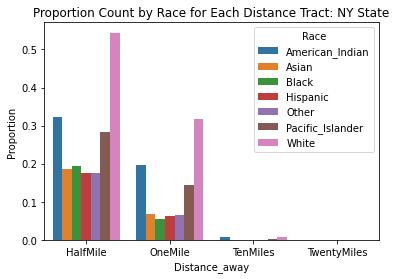

In [155]:
# Visualizing the racial distribution of proportions of food desserts at each distance
ny_prop_at_each_dist_melted = pd.melt(ny_prop_at_each_dist, id_vars='Race', var_name='Distance_away', value_name='Proportion')
sns.barplot(data=ny_prop_at_each_dist_melted, x='Distance_away', y='Proportion', hue='Race').set(title='Proportion Count by Race for Each Distance Tract: NY State')
plt.show()

This graph displays the proportion of the population of each race within New York State. From this initial observation, it appears that White, American Indian or Alaska native, and Native Hawaiian and Other Pacific Islander population appear to have the greatest proportion of people living far away from supermarkets. 

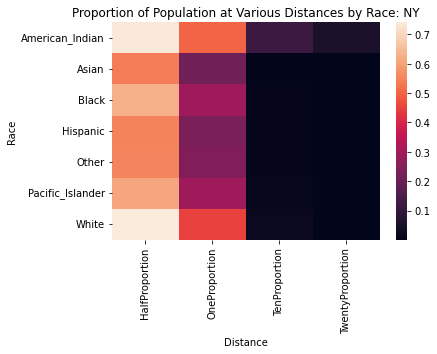

In [156]:
ny_prop_at_each_dist_heatmap = pd.melt(pop_prop_at_each_dist.drop(columns=['HalfMile','OneMile','TenMiles','TwentyMiles']),\
                                        id_vars='Race', var_name = 'Distance', value_name='Proportion')
heatmap_df = ny_prop_at_each_dist_heatmap.pivot("Race", "Distance", "Proportion")
ax = sns.heatmap(heatmap_df)
plt.title("Proportion of Population at Various Distances by Race: NY")
plt.show()

This heatmap is another visualization of the proportions in terms of NY State. Similar to the heatmap of the US, the colors get darker as the distance increases. For both the US and NY State, those who lived 10 miles and 20 miles away from a supermarket had a very low proportion of population of every race. However, in both heatmaps, the American Indian population had the greatest proportion of population within this tract at about 0.2 of its population in the 10 miles tract and 0.1 of its population in the 20 miles tract, which is the same found in the heatmap of the US. 

Below, we will conduct further analysis by looking at each distances on their own and comparing them to the distribution of the US.

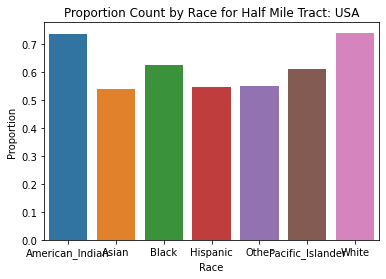

[Text(0.5, 1.0, 'Proportion Count by Race for Half Mile Tract: NY State')]

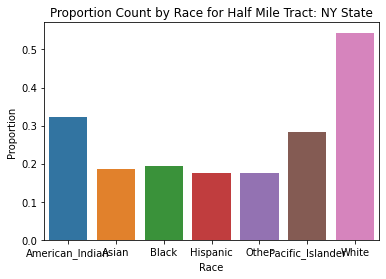

In [157]:
sns.barplot(data=cleaned_half, x='Race', y='Proportion').set(title='Proportion Count by Race for Half Mile Tract: USA')
plt.show()
sns.barplot(data=cleaned_ny_half, x='Race', y='Proportion').set(title='Proportion Count by Race for Half Mile Tract: NY State')

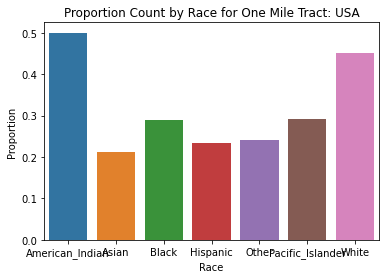

[Text(0.5, 1.0, 'Proportion Count by Race for One Mile Tract: NY State')]

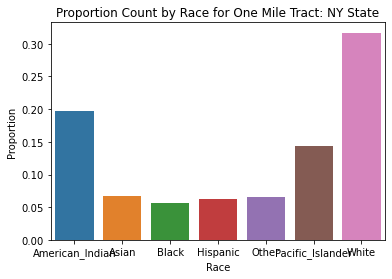

In [158]:
sns.barplot(data=cleaned_one, x='Race', y='Proportion').set(title='Proportion Count by Race for One Mile Tract: USA')
plt.show()
sns.barplot(data=cleaned_ny_one, x='Race', y='Proportion').set(title='Proportion Count by Race for One Mile Tract: NY State')

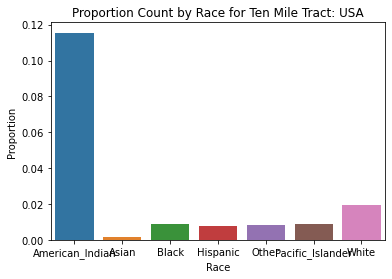

[Text(0.5, 1.0, 'Proportion Count by Race for Ten Mile Tract: NY State')]

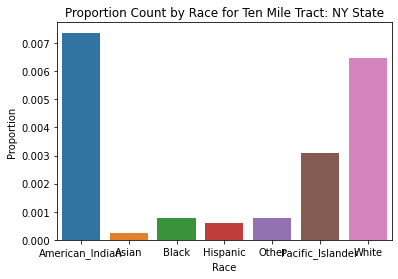

In [159]:
sns.barplot(data=cleaned_ten, x='Race', y='Proportion').set(title='Proportion Count by Race for Ten Mile Tract: USA')
plt.show()
sns.barplot(data=cleaned_ny_ten, x='Race', y='Proportion').set(title='Proportion Count by Race for Ten Mile Tract: NY State')

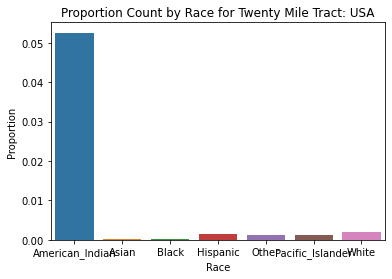

[Text(0.5, 1.0, 'Proportion Count by Race for Twenty Mile Tract: NY State')]

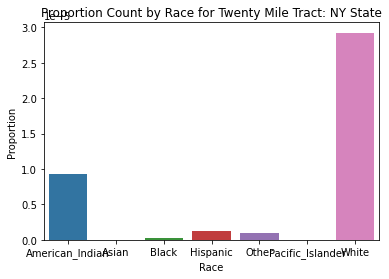

In [160]:
sns.barplot(data=cleaned_twenty, x='Race', y='Proportion').set(title='Proportion Count by Race for Twenty Mile Tract: USA')
plt.show()
sns.barplot(data=cleaned_ny_twenty, x='Race', y='Proportion').set(title='Proportion Count by Race for Twenty Mile Tract: NY State')

As seen in these graphs, the White, American Indian or Alaska native, and Native Hawaiian and Other Pacific Islander population  have above average proportion of food insecurity for distances below 20 miles from a supermarket within New York State. From 20 miles and further, only the White and American Indian or Alaska native population have above average proportions.

Comparing this distribution to that of the overall US food insecurity levels, the same races, White and American Indian or Alaska native, were the most food insecure. However, in NY state specificially, Native Hawaiian and Other Pacific Islander population also had above average proportions in the tracts less than 20 miles away. Additionally, it appears that ...


### Hypothesis Testing: NY State

,Race,Population,Proportion,p-val,Significant
0,American_Indian,3.455974e+04,0.323272,0.312,False
1,Asian,2.628393e+05,0.185066,0.745,False
2,Black,5.924514e+05,0.192742,0.720,False
3,Hispanic,6.036213e+05,0.176656,0.763,False
4,Other,3.583624e+05,0.176759,0.761,False
5,Pacific_Islander,2.482825e+03,0.283234,0.435,False
6,White,6.927099e+06,0.543687,0.023,True


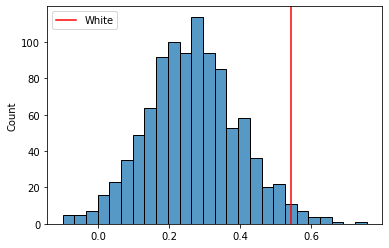

In [161]:
nyhalf_prop_mean = cleaned_ny_half['Proportion'].mean()
nyhalf_prop_std = cleaned_ny_half['Proportion'].std()

nyhalf_prop_hypo = get_p(cleaned_ny_half, nyhalf_prop_mean, nyhalf_prop_std)
nyhalf_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,2.110377e+04,0.197405,0.229,False
1,Asian,9.479964e+04,0.066749,0.708,False
2,Black,1.717682e+05,0.055881,0.756,False
3,Hispanic,2.148840e+05,0.062888,0.720,False
4,Other,1.331233e+05,0.065662,0.712,False
5,Pacific_Islander,1.263375e+03,0.144122,0.410,False
6,White,4.036151e+06,0.316785,0.029,True


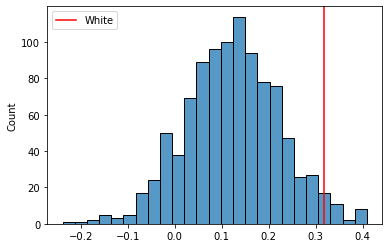

In [162]:
nyone_prop_mean = cleaned_ny_one['Proportion'].mean()
nyone_prop_std = cleaned_ny_one['Proportion'].std()

nyone_prop_hypo = get_p(cleaned_ny_one, nyone_prop_mean, nyone_prop_std)
nyone_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,787.270739,0.007364,0.061,False
1,Asian,346.265939,0.000244,0.800,False
2,Black,2408.879887,0.000784,0.750,False
3,Hispanic,2023.171552,0.000592,0.771,False
4,Other,1583.693025,0.000781,0.750,False
5,Pacific_Islander,27.135887,0.003096,0.453,False
6,White,82422.596879,0.006469,0.114,False


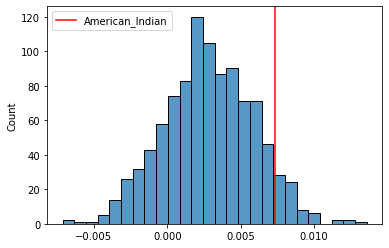

In [163]:
nyten_prop_mean = cleaned_ny_ten['Proportion'].mean()
nyten_prop_std = cleaned_ny_ten['Proportion'].std()

nyten_prop_hypo = get_p(cleaned_ny_ten, nyten_prop_mean, nyten_prop_std)
nyten_prop_hypo

,Race,Population,Proportion,p-val,Significant
0,American_Indian,1.000088,9.354839e-06,0.341,False
1,Asian,0.000265,1.867897e-10,0.697,False
2,Black,0.715675,2.328306e-07,0.686,False
3,Hispanic,4.505039,1.318449e-06,0.652,False
4,Other,2.110698,1.041080e-06,0.665,False
5,Pacific_Islander,0.000000,0.000000e+00,0.697,False
6,White,372.440094,2.923168e-05,0.014,True


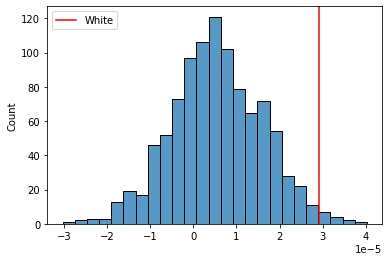

In [164]:
nytwenty_prop_mean = cleaned_ny_twenty['Proportion'].mean()
nytwenty_prop_std = cleaned_ny_twenty['Proportion'].std()

nytwenty_prop_hypo = get_p(cleaned_ny_twenty, nytwenty_prop_mean, nytwenty_prop_std)
nytwenty_prop_hypo

From the above hypothesis tests, we can reject the null hypothesis that there is no inequality in terms of access to food being more than 20 miles away from the White population. Although there is significance found for the white population at the half mile and one mile tract, this does not count toward our hypothesis as inaccess to food is defined as being beyond one mile away in urban areas and beyond 10 miles in rural areas.

We can also note that this is different from the national data analysis where we found significance in the American Indian population at the 10 and 20 mile tract, rather than the white population solely at the 20 mile tract.

Due to this finding, we will now explore if there is an underlying factor explain for the higher proportion of food inaccess in the 20 mile tracts for the White population specifically. 

### Hypothesis Testing for Regression: NY State

As a means of understanding if there is some relationship between the white population tracks from the five feature, as aforementioned in the orginal dataset for New York State.

These five features are:  
- low income population  
- count of kids between 0-17  
- count of seniors above 65  
- count of housing units with no vehicle  
- count of housing units receiving SNAP benefits  

This hypothesis test will also help us determine if levels of food insecurity in this population in NY State, which is the most at-risk population, as seen through our previous analysis, is similar to that of the national level for those population.

In [184]:
# Cleaning the dataframe to get only columns of interest for NY 
%sql reg_ny_df << SELECT County, TractLOWI AS LowIncome, TractKids AS Kids, TractSeniors AS Seniors, TractHUNV AS NoVehicle,\
TractSNAP AS SNAP FROM df WHERE State = 'New York'
reg_ny_df.head()

Returning data to local variable reg_ny_df


,County,LowIncome,Kids,Seniors,NoVehicle,SNAP
0,Albany,1163,644,218,191,298
1,Albany,2962,1946,401,880,974
2,Albany,2670,1297,859,697,653
3,Albany,245,149,1088,123,0
4,Albany,1445,531,679,488,146


In the above data frame, we are filtering out the feature variables (x) from the original dataset and also adding the boolean column (y) for New York State.

In [185]:
reg_ny_df.corr()

,LowIncome,Kids,Seniors,NoVehicle,SNAP
LowIncome,1.000000,0.630829,0.196947,0.558255,0.875548
Kids,0.630829,1.000000,0.481974,0.239307,0.488386
Seniors,0.196947,0.481974,1.000000,0.275894,0.121415
NoVehicle,0.558255,0.239307,0.275894,1.000000,0.552488
SNAP,0.875548,0.488386,0.121415,0.552488,1.000000


As seen when the process was completed for national level analysis, there is also a strong correlation between the SNAP program and low income. This can be attributed to the fact that the SNAP program was created to support low income people. To avoid multicollinearity, we will drop the SNAP variable when running the regression.

In [188]:
new_reg_ny_df = reg_ny_df.drop(columns='SNAP')
new_reg_ny_df.head()

,County,LowIncome,Kids,Seniors,NoVehicle
0,Albany,1163,644,218,191
1,Albany,2962,1946,401,880
2,Albany,2670,1297,859,697
3,Albany,245,149,1088,123
4,Albany,1445,531,679,488


This data frame is updated with the dropped SNAP column. Now we will normalize values to organize the data effectively.

In [189]:
means_ny = new_reg_ny_df[['LowIncome','Kids','Seniors','NoVehicle']].mean()
stds_ny = new_reg_ny_df[['LowIncome','Kids','Seniors','NoVehicle']].std()
norm_reg_ny_df = (new_reg_ny_df[['LowIncome','Kids','Seniors','NoVehicle']] - means_ny)/ stds_ny
norm_reg_ny_df.head()

,LowIncome,Kids,Seniors,NoVehicle
0,-0.095851,-0.480400,-0.917674,-0.382644
1,1.629584,2.154540,-0.385414,0.704500
2,1.349525,0.841118,0.946690,0.415752
3,-0.976311,-1.482163,1.612742,-0.489938
4,0.174618,-0.709085,0.423156,0.085980


This dataframe is the result of normalization.

In [190]:
#Filter tracts with greatest white for NY
most_white_tracts_ny = (ny_twenty.drop(columns=['State','County']).max(axis=1) == ny_twenty['White']) & (ny_twenty['White'] > 0)

We have created a variable `most_white_tracts_ny` to filter tracts with the greatest proportion of white population that was at risk for food insecurity in NY. As informed by our hypothesis testing, significance was found for the white population of the 20 mile tract. Thus, we restricted the variable for the white population proportion for the 20 mile tract.

Within this next dataframe, we will now generate summary statistics to understand if any features have a relevant relationship with the white population at the 20 mile distance

In [191]:
# Splitting above dataset to fit regression
X_train, X_test, y_train, y_test = \
train_test_split(norm_reg_ny_df, most_white_tracts_ny, test_size=0.3)

# Using statsmodel package to get summary statistics of the regression
model = sm.Logit(most_white_tracts_ny, norm_reg_ny_df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4907
Model:                          Logit   Df Residuals:                     4903
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                  -56.31
Time:                        15:03:02   Log-Likelihood:                -3401.2
converged:                       True   LL-Null:                       -59.345
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LowIncome      0.0010      0.046      0.021      0.983      -0.089       0.091
Kids          -0.0067      0.044     -0.153      0.878      -0.093       0.079
Seniors        0.0012      0.035      0.034      0.973      -0.067       0.070
NoVehicle     -0.0032      0.037     -0.088      0.930      -0.076       0.069
==============================================================================
"""

From the above summary statistics, we can see again that there are no significant p-values across the four features. We fail to reject the null hypothesis that there is no relationship between the features (low income, number of kids, number of seniors, and number of housing units without a vehicle) and white population tracts in New York State.


---

## Comparing Two Distributions

In [192]:
both_prop_dist = pd.DataFrame({'Race':cleaned_half['Race'],\
                               'NYS_half':cleaned_ny_half['Proportion'], 'US_half':cleaned_half['Proportion'],\
                               'NYS_one':cleaned_ny_one['Proportion'], 'US_one':cleaned_one['Proportion'],\
                               'NYS_ten':cleaned_ny_ten['Proportion'], 'US_ten':cleaned_ten['Proportion'],\
                               'NYS_twenty':cleaned_ny_twenty['Proportion'], 'US_twenty':cleaned_twenty['Proportion']})
both_prop_dist

,Race,NYS_half,US_half,NYS_one,US_one,NYS_ten,US_ten,NYS_twenty,US_twenty
0,American_Indian,0.323272,0.736394,0.197405,0.500249,0.007364,0.115463,9.354839e-06,0.052531
1,Asian,0.185066,0.540450,0.066749,0.212169,0.000244,0.001566,1.867897e-10,0.000261
2,Black,0.192742,0.626048,0.055881,0.290160,0.000784,0.008718,2.328306e-07,0.000178
3,Hispanic,0.176656,0.549026,0.062888,0.233282,0.000592,0.007739,1.318449e-06,0.001386
4,Other,0.176759,0.551826,0.065662,0.241492,0.000781,0.008525,1.041080e-06,0.001340
5,Pacific_Islander,0.283234,0.610743,0.144122,0.292074,0.003096,0.009084,0.000000e+00,0.001362
6,White,0.543687,0.741245,0.316785,0.450630,0.006469,0.019292,2.923168e-05,0.001930


The above dataframe is simply the proportion of the different racial groups aggregated into one dataframe for both the NYS and US distributions. We noticed that the proportion for the US is significantly larger for obvious reasons, so we will normalize the data to make them more comparable.

In [193]:
means = both_prop_dist.drop(columns='Race').mean()
stds = both_prop_dist.drop(columns='Race').std()

both_prop_dist_norm = (both_prop_dist.drop(columns='Race') - means)/stds
both_prop_dist_norm.insert(0, 'Race', both_prop_dist['Race'])
both_prop_dist_norm

,Race,NYS_half,US_half,NYS_one,US_one,NYS_ten,US_ten,NYS_twenty,US_twenty
0,American_Indian,0.405277,1.327701,0.687680,1.621773,1.535384,2.248951,0.320852,2.266565
1,Asian,-0.622489,-0.951430,-0.643869,-0.929866,-0.839802,-0.562102,-0.543595,-0.419659
2,Black,-0.565407,0.044206,-0.754622,-0.239066,-0.659712,-0.385586,-0.522097,-0.423918
3,Hispanic,-0.685029,-0.851682,-0.683214,-0.742857,-0.723618,-0.409753,-0.421776,-0.361827
4,Other,-0.684270,-0.819111,-0.654949,-0.670145,-0.660559,-0.390340,-0.447408,-0.364208
5,Pacific_Islander,0.107530,-0.133817,0.144661,-0.222118,0.111488,-0.376550,-0.543612,-0.363085
6,White,2.044387,1.384133,1.904313,1.182278,1.236818,-0.124621,2.157636,-0.333868


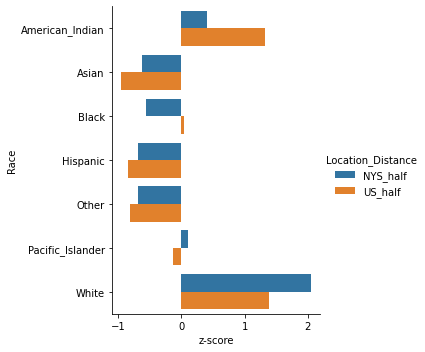

In [194]:
both_prop_half_melted = pd.melt(both_prop_dist_norm[['Race','NYS_half','US_half']], id_vars='Race', var_name='Location_Distance', value_name='z-score')
sns.catplot(data=both_prop_half_melted, x='z-score',y='Race',kind='bar',hue='Location_Distance')

This catplot displays the differnece in the z-score of race reflective of the US and NY State in the half mile tract.

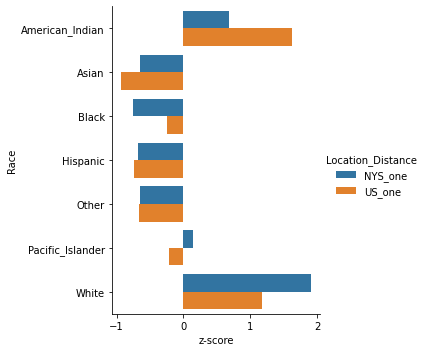

In [195]:
both_prop_one_melted = pd.melt(both_prop_dist_norm[['Race','NYS_one','US_one']], id_vars='Race', var_name='Location_Distance', value_name='z-score')
sns.catplot(data=both_prop_one_melted, x='z-score',y='Race',kind='bar',hue='Location_Distance')

This catplot displays the differnece in the z-score of race reflective of the US and NY State in the one mile tract.

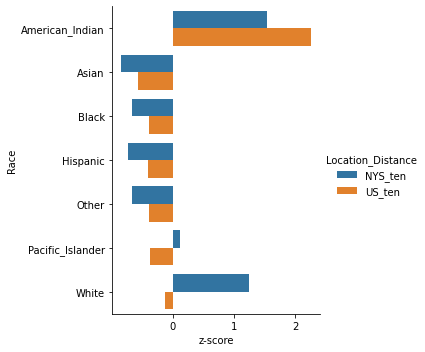

In [196]:
both_prop_ten_melted = pd.melt(both_prop_dist_norm[['Race','NYS_ten','US_ten']], id_vars='Race', var_name='Location_Distance', value_name='z-score')
sns.catplot(data=both_prop_ten_melted, x='z-score',y='Race',kind='bar',hue='Location_Distance')

This catplot displays the differnece in the z-score of race reflective of the US and NY State in the ten mile tract.

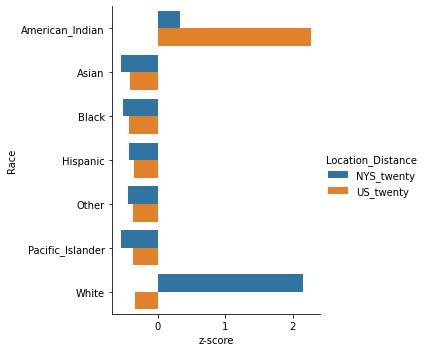

In [197]:
both_prop_twenty_melted = pd.melt(both_prop_dist_norm[['Race','NYS_twenty','US_twenty']], id_vars='Race', var_name='Location_Distance', value_name='z-score')
sns.catplot(data=both_prop_twenty_melted, x='z-score',y='Race',kind='bar',hue='Location_Distance')

This catplot displays the differnece in the z-score of race reflective of the US and NY State in the twenty mile tract.

### Regression

For this regression, we are seeing if we can we predict the proportion of people living in a "food desert" based on racial distribution.

Here, we are creating four dataframes. Each of dataframes is a combination of either national or New York data and urban or rural data. Additionally, census tract is included as the ID variable, as data is given at the census-tract-level.

In [93]:
%sql urban_national << SELECT CensusTract, POP2010 as Population, lawhite1 as White, lablack1 as Black,\
laasian1 as Asian, lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other,\
lahisp1 as Hispanic FROM df WHERE Urban == '1'

Returning data to local variable urban_national


In [94]:
%sql urban_nys << SELECT CensusTract, POP2010 as Population, lawhite1 as White, lablack1 as Black,\
laasian1 as Asian, lanhopi1 as Pacific_Islander, laaian1 as American_Indian, laomultir1 as Other,\
lahisp1 as Hispanic FROM df WHERE State == 'New York' AND Urban == '1'

Returning data to local variable urban_nys


In [95]:
%sql rural_national << SELECT CensusTract, POP2010 as Population, lawhite10 as White, lablack10 as Black,\
laasian10 as Asian, lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other,\
lahisp10 as Hispanic FROM df WHERE Urban == '0'

Returning data to local variable rural_national


In [96]:
%sql rural_nys << SELECT CensusTract, POP2010 as Population, lawhite10 as White, lablack10 as Black,\
laasian10 as Asian, lanhopi10 as Pacific_Islander, laaian10 as American_Indian, laomultir10 as Other,\
lahisp10 as Hispanic FROM df WHERE State == 'New York' AND Urban == '0'

Returning data to local variable rural_nys


This function allows the regression to be run on each of the four dataframes. First, the proportion of each race per tract is calculated. Next, the dataset is melted and dummy variables are created. Then, the model is initialized and run. Lastly, metrics incuding mean squared error, root mean squared error, and mean absolute error are calculated.

In [149]:
def run_regression(dataset):
    dataset = dataset.dropna()
    dataset = dataset.astype(float)
    
    # calculating proportion of race per tract
    dataset['White'] = dataset['White'] / dataset['Population']
    dataset['Black'] = dataset['Black'] / dataset['Population']
    dataset['Asian'] = dataset['Asian'] / dataset['Population']
    dataset['Pacific_Islander'] = dataset['Pacific_Islander'] / dataset['Population']
    dataset['American_Indian'] = dataset['American_Indian'] / dataset['Population']
    dataset['Other'] = dataset['Other'] / dataset['Population']
    dataset['Hispanic'] = dataset['Hispanic'] / dataset['Population']
    
    # preparing dataset for regression
    dataset = dataset.drop(['Population'],axis=1)
    dataset = dataset.dropna(axis=0)
    melted_dataset = pd.melt(dataset, id_vars='CensusTract', var_name='Race',value_name='Proportion')
    melted_dummies_dataset = pd.concat([melted_dataset, pd.get_dummies(melted_dataset['Race'])], axis=1)
    
    # creating a train and test dataset
    X = melted_dummies_dataset[['American_Indian','Asian','Black','Hispanic','Other','Pacific_Islander','White']]
    Y = melted_dummies_dataset['Proportion']
    print('X shape',X.shape)
    print('Y shape',Y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    # regression model
    model = LinearRegression()
    model.fit(X_train,y_train)
    print('Coefficient:',model.coef_)
    print('Intercept:',model.intercept_)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predicted_american_indian = model.predict([[1,0,0,0,0,0,0]])
    predicted_white = model.predict([[1,0,0,0,0,0,0]])
    
    msetrain = np.mean(np.square(np.subtract(y_train, y_train_pred)))
    msetest = np.mean(np.square(np.subtract(y_test, y_test_pred)))
    
    rmsetrain = math.sqrt(msetrain)
    rmsetest = math.sqrt(msetest)
    
    maetrain = np.mean(np.abs(np.subtract(y_test, y_test_pred)))
    maetest = np.mean(np.abs(np.subtract(y_test, y_test_pred)))
    
    print('MSE:',msetrain, msetest)
    print('RMSE:',rmsetrain, rmsetest)
    print('MAE:',maetrain, maetest)

Below are the results for each of the four dataframes:

In [155]:
run_regression(urban_national)

X shape (386204, 7)
Y shape (386204,)
Coefficient: [-1.05187495e+09 -1.05187495e+09 -1.05187495e+09 -1.05187495e+09
 -1.05187495e+09 -1.05187495e+09 -1.05187495e+09]
Intercept: 1051874954.0357033
MSE: 0.012721222650627292 0.012668371271004801
RMSE: 0.11278839767736437 0.11255385942296604
MAE: 0.0482033225793975 0.0482033225793975


In [156]:
run_regression(urban_nys)

X shape (29281, 7)
Y shape (29281,)
Coefficient: [-8.62119004e+11 -8.62119004e+11 -8.62119004e+11 -8.62119004e+11
 -8.62119004e+11 -8.62119004e+11 -8.62119004e+11]
Intercept: 862119003585.239
MSE: 0.007901737349781624 0.006847732245465596
RMSE: 0.08889171699197639 0.08275102564600391
MAE: 0.027274786433728816 0.027274786433728816


In [157]:
run_regression(rural_national)

X shape (121513, 7)
Y shape (121513,)
Coefficient: [2.6110573e+08 2.6110573e+08 2.6110573e+08 2.6110573e+08 2.6110573e+08
 2.6110573e+08 2.6110573e+08]
Intercept: -261105729.92620358
MSE: 0.00590667198247798 0.005847153844837318
RMSE: 0.07685487611386788 0.07646668454194491
MAE: 0.02265858886219336 0.02265858886219336


In [158]:
run_regression(rural_nys)

X shape (4809, 7)
Y shape (4809,)
Coefficient: [2.15054354e+10 2.15054354e+10 2.15054354e+10 2.15054354e+10
 2.15054354e+10 2.15054354e+10 2.15054354e+10]
Intercept: -21505435387.43293
MSE: 0.0019381336706538882 0.0030676291125248966
RMSE: 0.044024239580643394 0.05538618160267863
MAE: 0.010645903292507895 0.010645903292507895


---

# Interpretation and Conclusion 

## Interpretation
We generally conducted our data analysis with a _big to small_ approach, which our interpretation will follow in terms of organization. 

### 1) National Data Analysis 
- We began by conducting our analysis of data on the national level, calculating the proportions of each race that lived at varying distances from their local supermarkets and producing multiple visualizations for this data. 
- Upon visualizing these proportions on a heat map and multiple bar plots, we noticed that the Native American population had a __significantly higher proportion of people with lower access to supermarkets__ at each distance. Specifically, at every recorded distance, this group was __above the national mean__ for proportion of population living at that distance. 
- It is necessary to note that the white population was also above the national mean for two plots, but these were the half-mile and one-mile distance-- this was less concerning, since the definition of _food desert_ varies between 1 mile and 10 miles depending on one's type of geographical residence. 
- These trends motivated us to look further into the Native American population in our data analysis, because their proportions were especially high at the ten and twenty mile marks compared to other races.

#### 1a) Hypothesis Testing 
    
- To confirm our suspicion that there exists a disparity in terms of Native American food access (and directly answer our first research question), we conducted hypothesis testing for each race using our cleaned national data. 
- This testing, in which we calculated the p-value for each race in relation to each of the other 6 racial groups, led us to the conclusion that there __does exist a statistically significant difference in terms of access to food in the US across race, specifically for the Native American population at the one, ten, and twenty mile distance increments__. This was the most significant takeaway from this stet of hypothesis tests.

#### 1b) Focus on Native American Population, further hypothesis testing

- To delve deeper into our finding that there is a disparity in food access between the Native American population and other races in the U.S., we isolated the U.S. population tracts with the highest amounts of Native American residents. __We found that Arizona, New Mexico, and Alaska have the most Native Americans that live 20 or more miles away from a supermarket.__
- Using this subset of the population, we pulled in five variables (low income population, youth count, senior count, # housing units with no vehicle, # housing units receiving SNAP benefits) from the original dataset to test whether they had a notable relationship with the Native American population tracts. __We found through our logistic regression that there was no significant relationship between any of the chosen variables and the likelihood of being in a Native American tract.__
- The general takeaway from this portion of our analysis is that income level, age group, and not owning a vehicle do not have a significant relationship with the Native American tracts we chose to analyze. This does not imply that there is no interaction whatsoever between these factors (we know that there is very often interaction between income level and race in socioeconomic disparities), but with our chosen population of Native Americans, we did not find a significant relationship to interpret.


### 2) New York State Analysis 
- We continued our analysis of data at the state level, essentially reproducing the results from our national analysis but only for New York State. Upon visualizing these proportions, we noticed slightly different trends than we did for our national data.
- Once again, the Native American population had a __significantly higher proportion of people with lower access to supermarkets__ at each distance. At every recorded distance, this group was __above the national mean__ for proportion of population living at that distance. 
- However, at every recorded distance, the white racial group was _also_ above the national mean, and the Pacific Islander racial group was above for every distance except the 20 mile distance. These were two novel findings that __indicates New York state may not reflect national levels of food access inequality__.

#### 2a) Hypothesis Testing (NY)
- Our hypothesis testing on the New York data, which followed the same procedure as the hypothesis testing on US data, confirmed the trends that our visualizations showed. 
- __We found that in there exists a statistically significant difference in terms of access to food in New york across race, specifically for the white population at the half, one, and twenty mile distance increments__. Due to the definition of "food desert," however, we do not consider the half and one mile disparities to be a concern, and focus solely on the white population in the 20 mile tract for the rest of this state analysis. 
- This second hypothesis test indicates that __New York does not reflect national disparities in food access__. 

#### 2b) Focus on white population, further hypothesis testing
- Due to our finding of a disparity in food access for white Americans in New York, we conducted a logistic regression similar to the one ran on the US Native American data. 
- __We found that there is no significant relationship between income, number of kids, number of seniors, and ownership of a vehicle for the white population tract living 20 miles from a supermarket in New York.__ 
    

### 3) Comparing Two Distributions
- Continuing to test our second hypothesis, we decided to create a more direct comparison between US and New York data beyond our hypothesis testing. Using z-scores, we compared the distribution of the proportion of each racial group living at each geographical distance in order to determine how NY food access levels compare to national levels. 
- The most notable differences between NY and the US are found at twenty mile distance, which aligns with our earlier hypothesis testing. __For Americans living 20 miles from their nearest supermarket, there is a disparity for Native Americans on the national level, but a disparity for white Americans in New York state.__
- This answers our second hypothesis: __New York does not reflect national levels of food access inequality; white Americans are uniquely disadvantaged in NYS.__ 


### 4) Regression 

- When modeling the seven races jointly, there tended to be __similarities between national and New York coefficients.__ Both national and New York urban tracts resulted in positive coefficients for urban tracts, whereas national and New York rural tracts resulted in negative coefficients. These relationships make sense and align with conclusions from previous sections regarding similar racial proportions between national and New York tracts. 
- The RMSE and MAE between the training and testing sets are pretty similar, so we should not be concerned about overfitting.



## Conclusion

### Explanation for findings / confidence in interpretations

The two biggest takeaways from our analysis are 1) the high proportion of Native Americans living 1-20 miles away from the nearest supermarket nationally, and 2) the high proportion of white Americans living 20 miles away from the nearest supermarket in New York state.

While we are relatively confident in the source of the rest of our data, as it is pulled from the U.S. Census and major U.S. surveys (see Data Limitations for more information), our current findings do not entirely line up with prior research on food deserts. Research at JHU (https://hub.jhu.edu/magazine/2014/spring/racial-food-deserts/) found that _black and Hispanic neighborhoods_ have fewer large supermarkets and more small grocery stores than white neighborhoods, but our data does not find a significant disparity between these two groups and other racial groups on both the national and state level. 

It is possible that the reason these findings (and others in the field of social science research) do not line up with our analysis is that their data is more specific than our dataset. Our dataset's sources of supermarket data (meant to represent "sources of affordable and nutritious food") could provide much more detail-- it only pulls from two lists of supermarkets and does not include smaller grocery stores. This may create a lack of context necessary to see disparities experienced by Black and Hispanic communities in the U.S.

### Real-life application & implications for lawmakers

One could take the findings of our data analysis and conclude that __more supermarkets need to be placed in U.S. regions with Native American communities who live 10-20 miles from a supermarket, and in New York regions with white communities who live 20+ miles from a supermarket.__ While this is a solid recommendation to lawmakers that would likely improve the disparity that we find in our data, it is most likely omitting other important factors not captured by our analysis. 

Beyond revealing the need for more supermarkets in certain areas shown to lack food access, these findings are also valuable because they create a host of new questions for our research topic. Among them are:
1. Historically, what does food access look like for Native Americans? How do the majority of Native Americans receive their food? (A quick Google search shows that there exists a program called "The Food Distribution Program on Indian Reservations (FDPIR)", which could explain why a portion of Native Americans do not need access to local supermarkets). 
2. Why does New York state have a disparity (negatively impacting white Americans) that is not present at the national level? What is the cause for this? 
3. Is New York City, which inhabits 43% of the New York state population, responsible for the food access disparity, or is this disparity located in other New York regions?


### Next steps

If we were to continue this analysis, there are a number of data analyses that we'd be interested in exploring. 
1. _More specific supermarket data_ - As stated above, it would be valuable to have data that specified the type of food that each race had access to. It is possible that Black and Hispanic communities were not shown to be disadvantaged because these tracts technically have access to supermarkets, but they are not "good" supermarkets that provide nutritious and affordable food. 
2. _Interactions with other socioeconomic metrics_ - While we did have access to data on income level and pulled it in at specific points of our analysis on race, it would be interesting to conduct a large scale comparison between race and income level in relation to food access. This is because food access is known to have a strong correlation with income level. 
3. _Food access in relation to other necessities_ - It would be very interesting to see if the trends we note in terms of food access are similar for healthcare access, education access, and other resources that affect life quality.

# Acknowledgements

We would like to thank all people and resources that have helped us through the course of this project. Specifically, we would like to thank Professor Minmo and Professor Koenecke for teaching the concepts of INFO 2950 that were integral to this project, including using various packages, creating visualizations, hypothesis testing, and interpretation techniques. Moreover, we would like to thanks the Teaching Assistants of our respective discussions as well as the reviewers of our past phases for their feedback and suggestions that helped us improve our analysis. We would also like to thank users on Stack Overflow for posting their questions! These posts helped inspire us to change our methodology and troubleshoot issues we were having, such as for the heatmap.

# Questions for Reviewers

1. For the data cleaning appendix, do we remove all data cleaning elements from this notebook?
2. We are having a hard time interpreting our regression results (see the last section before our Intepretation/Conclusion section). 
    1. Do our current X and Y variables make sense? 
    2. Does logistic regression make more sense to perform over linear regresssion given the variables we are working with? 
    3. How would you suggest we improve our regression? 
3. Is our interpretation/conclusion section missing any key components?
4. Is our overall project lacking any key components? What needs clarity?